In [1]:
import pymc as pm
import numpy as np
import arviz as az
from pymc.math import logit, exp
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import xarray as xr

%load_ext lab_black
%load_ext watermark

# Priors as hidden mixtures

Adapted from [Unit 9: cumulative2.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit9/cumulative2.odc).

Associated lecture video: Unit 9 lesson 8

## Problem description

Use of ```cumulative``` as a check for outliers

How consistent are the data with the model? Check ```cumulative(y[i], y[i])```.

The first y[i] specifies the distribution of y[i]'s, the second is the argument/observation. The output is empirical cdf of y[i]s evaluated at y[i].

Values close to 0 or 1 are potential outliers.

## Notes

The idea here seems to be based on the [probability integral transform](https://en.wikipedia.org/wiki/Probability_integral_transform). The problem I'm having is I don't know exactly how the BUGS ```cumulative``` function works - it doesn't seem to be in the docs. Is it using KDE to approximate the cdf or what?

For now, I recommend checking out plots like the examples below to look for outliers. I'll try to come back to this example in the future.

In [2]:
# fmt: off
y = np.array(
    [0.0, 1.0, 2.0, -1.0, 0.4, -0.5, 0.7, -1.2, 0.1, -0.4, 
     0.2, -0.5, -1.4, 1.8, 0.2, 0.3, -0.6, 1.1, 5.1, -6.3]
)
# fmt: on

In [3]:
with pm.Model() as m:
    theta = pm.Flat("theta")
    log_sigma = pm.Flat("log_sigma")
    tau = pm.Deterministic("tau", 1 / exp(2 * log_sigma))

    pm.Normal("y", mu=theta, tau=tau, observed=y)

    trace = pm.sample(2000)

    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, log_sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


In [4]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.052,0.497,-0.863,0.991,0.007,0.006,5175.0,4495.0,1.0
log_sigma,0.754,0.169,0.434,1.062,0.002,0.002,4799.0,4509.0,1.0
tau,0.234,0.077,0.101,0.380,0.001,0.001,4799.0,4509.0,1.0


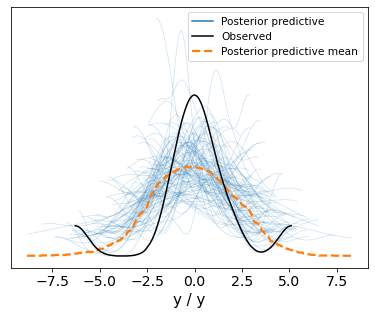

In [5]:
az.plot_ppc(trace, num_pp_samples=100)
plt.show()

Doesn't look like our posterior does a good job of fitting the observed data because of the outliers.

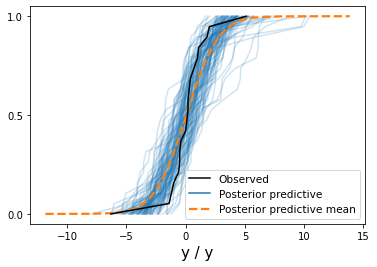

In [6]:
az.plot_ppc(trace, kind="cumulative", num_pp_samples=100)
plt.show()

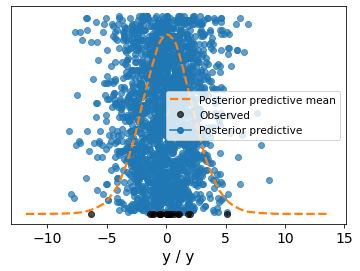

In [7]:
az.plot_ppc(trace, kind="scatter", num_pp_samples=100)
plt.show()

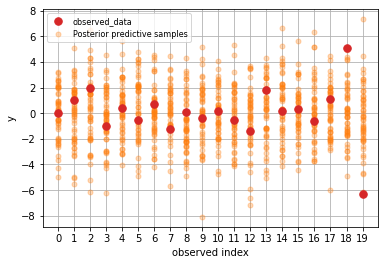

In [24]:
idx = list(range(20))

az.plot_lm(
    idata=trace,
    y="y",
    x=idx,
    plot_dim="y_dim_0",
    kind_model="hdi",
    textsize=8,
)
plt.xlabel("observed index")
plt.xticks(idx)
plt.show()

You can see the last two datapoints at indices 18 and 19 are not predicted well by the posterior. If it was fitting well, you would see the observed data close to the center of the posterior predictive values at all indices.

In [9]:
%watermark -n -u -v -iv -p aesara,aeppl

Last updated: Sat Jul 30 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

aesara: 2.7.3
aeppl : 0.0.31

pymc      : 4.0.1
arviz     : 0.12.1
matplotlib: 3.5.2
numpy     : 1.23.1
xarray    : 2022.6.0

